<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Marc Spiegelman, Template from Kyle Mandli</td>
</table>


In [1]:
# load the standard packages
import numpy as np
from scipy.optimize import fsolve, brentq
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
plt.rcParams["figure.figsize"] = [8,6]
plt.rcParams['font.size'] = 16

#some convenience functions for converting temperatures
toCelsius = lambda T: T - 273.15
toKelvin = lambda T: T + 273.15

# Example Usage of ThermoCodegen python bindings

This notebook will demonstrate  how to use functions from the ThermoCodegen generated fo-fa system to tackle a range of problems including

* Extracting thermodynamic properties of endmembers, phases and reaction objects
* Construction of the Equilibrium Phase Diagram for the Fo-Fa melting loop
* Simple isothermal reaction-path modeling in python

## Load the ThermoCodegen python bindings for the fo-fa reactive system

To use the thermocodegen generated python bindings, requires that the `py_fo_fa_binary` module is in your python path

if you are using modules,  this can be accomplished by running

```bash
cd ../../reactions/fo_fa_binary
module load ./fo_fa_binary.module
```

or by extending your PYTHONPATH to include

```bash
../../reactions/fo_fa_binary/lib/<python-version>/site-packages
```

where the appropriate python version can be deduced from either the module or the singularity environment file `fo_fa_binary.senv`

Once you have extended your python path, restart jupyter-lab and continue


### Import the ThermoCodegen object

In [2]:
import py_fo_fa_binary as py_fo_fa

### Extract the reaction object and provide a more detailed report

`py_fo_fa` will contain python objects for all phases and endmembers as well as a reaction object that provides information on a set of reactions over the space of endmembers and phases.
The name of the reaction object will the the same name as the library in the `.rxml` file.

The reaction object here is  `py_fo_fa_binary.fo_fa_binary` which we load and have it report version, phases and endmembers.

In [3]:
rxn = py_fo_fa.fo_fa_binary()
rxn.report()

Reaction object: fo_fa_binary

Phase 0 Olivine (Ol)
     Endmember 0 Forsterite_berman : Mg2SiO4_(Ol)
     Endmember 1 Fayalite_berman : Fe2SiO4_(Ol)
Phase 1 Liquid (Liq)
     Endmember 0 Forsterite_xmelts : Mg2SiO4_(Liq)
     Endmember 1 Fayalite_xmelts : Fe2SiO4_(Liq)

Reaction 0
     Mg2SiO4_(Ol) -> Mg2SiO4_(Liq)
Reaction 1
     Fe2SiO4_(Ol) -> Fe2SiO4_(Liq)


This report shows that the system is composed of two solution phases, Olivine and Liquid.  And each phase  is composed of two Endmembers, one Forsteritic the other Fayalitic.

For this model, the Olivine endmembers use a Berman (1988) mineral model.  The Liquid uses a Ghiorso and Sacks, xMelts model.

It is often useful to identify the indices for phases and endmembers for future use (report should really return a dictionary with this information)

In [4]:
iOl = 0 
iLq = 1
kFo = 0
kFa = 1

We can also extract the individual phase objects directly.  The names of all available phases in the thermocodegen object are given in the dictionary returned from 

In [5]:
py_fo_fa.phase_info()

{'Abbrev': ['Liq', 'Ol'],
 'ClassName': ['Liquid', 'Olivine'],
 'PhaseType': ['solution', 'solution']}

In [6]:
Ol = py_fo_fa.Olivine()
Lq = py_fo_fa.Liquid()

## Demonstrate some of the interfaces to the reaction and phase objects

### Phase Objects

All phase objects share the same interfaces as `thermoengine.coder` generated phases.  Here we demonstrate a few including

* Phase Name and Formula
* list of endmember formulas
* Gibbs Free Energy
* Entropy
* Volume

Set a reference temperature, pressure and composition

In [7]:
T=1800. # K
P=10000 # bars
n = [0.9, 0.1] # list of moles of each end_member

In [8]:
for phase in [Ol, Lq]:
    K = phase.endmember_number()
    print('{}:'.format(phase.name()))
    print('\t{} endmembers:\t{}'.format(K, [phase.endmember_name(k) for k in range(K)]))
    print('\tFormula:\t{}'.format(phase.formula(T,P,n)))
    print('\tG:\t\t{} J'.format(phase.g(T,P,n)))
    print('\ts:\t\t{} J/K'.format(phase.s(T,P,n)))
    print('\tV:\t\t{} J/bar'.format(phase.v(T,P,n)))
    print()

Olivine:
	2 endmembers:	['Forsterite_berman', 'Fayalite_berman']
	Formula:	Mg1.800Fe0.200SiO4
	G:		-2510212.7887425087 J
	s:		392.4643121296209 J/K
	V:		4.637395693946682 J/bar

Liquid:
	2 endmembers:	['Forsterite_xmelts', 'Fayalite_xmelts']
	Formula:	Mg1.800Fe0.200SiO4
	G:		-2492186.0452908776 J
	s:		435.4638368888722 J/K
	V:		4.9588916422093 J/bar



In addition,  thermodynamic properties of endmembers can also be retrieved directly from the python module, or from the phases themselves

### Reaction Objects
The Reaction objects also provide thermodynamic properties of all phases and endmembers involved in reactions as a function of 
$T$, $P$ and composition of *all* phases $C$ (usually in mass fraction) or $X$ in mol fractions.

Here we  calculate the chemical potentials of all components $\mu_i^k$ as well as the Affinities of the two reactions 

$$
    A_j = \sum_{i,k} \nu_{i,j}^k\mu_i^k
$$

at a fixed Temperature, Pressure and bulk composition

$$
    T = 1600^\circ \mathrm{C},\quad P= 1000\, \mathrm{bar},\quad X = \begin{bmatrix} \begin{bmatrix} 0.6 & 0.4 \\ \end{bmatrix} \\ \begin{bmatrix} 0.4 & 0.6 \\ \end{bmatrix}\\ \end{bmatrix}
$$

Where each row of $X$ is the composition of phase $i$ and $X[i][k]$ contains the mole fraction of component $k$ in phase $i$. 
Thus $X[0]$ contains the composition of phase 0 (Olivine) which is composed of 0.6 moles of the Forsterite endmember and 0.4 moles of the Fayalitic endmember.  

**Note**: in general,  different phases can have different numbers of end-members and $X$ is not necessarily a regular array.  To initialize the proper shape for $X$ we can use the convenience function `rxn.zero_C()` which returns a nested list of the right shape.

We will also convert composition from mole fractions to weight fractions with the convenience function `rxn.X_to_C()`

In [9]:
# set reference parameters

T = toKelvin(1600)
P = 1000. #bars
X = rxn.zero_C()
X[0] = [0.6, 0.4]
X[1] = [0.4, 0.6]

# convert mole fraction X to mass fraction C
C = rxn.X_to_C(X)

print('T = {} C'.format(toCelsius(T)))
print('P = {} bars'.format(P))
print('X = {}'.format(X))
print('C = {}'.format(C))



T = 1600.0 C
P = 1000.0 bars
X = [[0.6, 0.4], [0.4, 0.6]]
C = [[0.5087539256792306, 0.4912460743207694], [0.3152018415680212, 0.6847981584319788]]


#### Calculate chemical potentials for the reaction object and the individual phases

The method ```M = rxn.Mu(T,P,C)``` returns a nested list of the same shape as $C$ such that `M[i][k]`$\equiv\mu_i^k$

In [10]:
print('Chemical Potentials:     {}'.format(rxn.Mu(T,P,C)))
print('Chemical Potential Ol:    {}'.format(Ol.mu(T,P,X[0])))
print('Chemical Potential Lq:    {}'.format(Lq.mu(T,P,X[1])))

Chemical Potentials:     [[-2640516.402703267, -2083007.6582828918], [-2631493.842372724, -2101124.7319794055]]
Chemical Potential Ol:    [-2640516.402703267, -2083007.6582828918]
Chemical Potential Lq:    [-2631493.842372724, -2101124.7319794055]


#### Calculate affinity of the two melting reactions

The method ```A = rxn.A(T,P,C)``` returns a list of affinities for the two melting reactions in the system 

* Reaction 0: Fo$_\mathrm{Ol}\rightarrow$Fo$_\mathrm{Lq}$
* Reaction 1: Fa$_\mathrm{Ol}\rightarrow$Fa$_\mathrm{Lq}$

In [11]:
print('Affinities:          {} J/K/mol'.format(rxn.A(T,P,C)))

Affinities:          [-9022.560330543201, 18117.07369651366] J/K/mol


Thus at this specified $T$, $P$ and composition $C$, Olivine would prefer to be more Mg rich and the liquid more Fe rich, as the   Forsterite endmember moves from liquid to solid, and the Fayalite endmember moves from solid to liquid.

#### Calculate density, heat capacity, $\alpha$, $\beta$, and specific entropy of all phases

Commonly used thermodynamic properties for all phases involved in reactions can also be returned by the reaction object.  The most common are:

* Density: $\rho$
* Heat Capacity: $C_p$
* specific Entropy: $s$
* Thermal Expansivity: $\alpha$
* Compressibility: $\beta$

As the reaction objects are primarily designed for use with conservation codes,  both Heat capacity and entropy are per unit mass rather than on a molar basis.

In [12]:
print('Density:          {} \t\tg bar/J'.format(rxn.rho(T,P,C)))
print('Heat Capacity:    {} \t\tJ/(K g)'.format(rxn.Cp(T,P,C)))
print('Entropy:          {} \t\tJ/(k g)'.format(rxn.s(T,P,C)))
print('alpha:            {} \t1/K'.format(rxn.alpha(T,P,C)))
print('beta:             {} \t1/bar'.format(rxn.beta(T,P,C)))


Density:          [34.84902525474675, 33.482113981078435] 		g bar/J
Heat Capacity:    [1.1876956409769128, 1.4143332017127481] 		J/(K g)
Entropy:          [2.5886347714053017, 2.829836794799008] 		J/(k g)
alpha:            [5.163992974474732e-05, 0.00010323658843176311] 	1/K
beta:             [7.193095868369965e-07, 4.313066144398183e-06] 	1/bar


#### Calculate Kinetic reaction terms $\Gamma_i^k$ and $\Gamma_{i}$

For this problem,  we have modeled the kinetic mass transfer rates for each component $k$ in phase $i$ using

$$
    \Gamma_i^k = \sum_j \nu_{i,j}^k R_j(T,P,C,\mathbf{\Phi})
$$

where $\nu_{i,j}^k$ is the stoichiometric coefficient for component $k$ in phase $i$ for the $j$th reaction (with positive coefficients for products and negative coefficients for reactants).  For this problem, the mass transfer rate of each reaction $R_j$ is described in the notebook `Generate_reactions.ipynb` and modeled using

$$
R_j = r(T)S(\mathbf{\Phi})\frac{A_j(T,P,C)}{RT}
$$

where 

* $r(T)$ is a reaction rate in mass/unit area/time
* $S(\mathbf{\Phi)}$ is the available specific surface area of reactants which depends on their phase fractions $\mathbf{\Phi}$
* and $A_j/RT$ is the affinity of reaction $j$ scaled by $RT$ where $R$ is the gas constant.  

The mass transfer rate for phase $i$ is simply

$$
\Gamma_i = \sum_k \Gamma_i^k
$$

Note,  these kinetic reaction rates will be zero if the system is in equilibrium $A_j=0$ or there are no reactants available $S=0$

As before $\Gamma_{i}^k$ has the same shape as $C$, and $\Gamma_i$ is a vector of length $N$ (the number of phases)

In [13]:
# here we will assume both phases are present
Phi = [ 0.5, 0.5]
print('Kinetic rate Gamma_ik:          {}'.format(rxn.Gamma_ik(T,P,C,Phi)))
print('phase Kinetic rate Gamma_i:     {}'.format(rxn.Gamma_i(T,P,C,Phi)))

Kinetic rate Gamma_ik:          [[0.24020372347985774, -0.4823230215186129], [-0.24020372347985774, 0.4823230215186129]]
phase Kinetic rate Gamma_i:     [-0.24211929803875515, 0.24211929803875515]


Thus at these conditions $\Gamma_0<0$ which implies olivine is melting and $\Gamma_1>0$ implies melt is being produced at the same rate.

## Phase Diagram

Given thermodynamic properties and affinities for all the reactions, it is relatively straighforward to calculate the equilibrium phase diagram for this simple system

### Calculate the Equilibrium phase loop at constant Pressure.

In equilibrium,  the affinities of both reactions must be 0, which at fixed $T$, and $P$ becomes a non-linear system of equation for the composition of Olivine and Liquid phases.  Because the compositions of any phase must add to one,  this becomes two equations in the two unknowns 
$c_{Ol}^{Fo}$ and $c_{Lq}^{Fo}$ as 

$$
\begin{align}
    A_0[T,P,C^*] &= 0\\
    A_1[T,P,C^*] &= 0\\
\end{align}
$$

where
$$
    C^*(c_{Ol}^{Fo},c_{Lq}^{Fo}) = \begin{bmatrix} \begin{bmatrix} c_{Ol}^{Fo} & 1- c_{Ol}^{Fo} \\ \end{bmatrix} \\ \begin{bmatrix} c_{Lq}^{Fo} & 1.-c_{Lq}^{Fo} \\ \end{bmatrix}\\ \end{bmatrix}
$$

Numerically, however, it is better to find the zeros of the scaled affinities $A_j/RT$.  

The following routine first finds the melting points of pure endmembers $T_{min}$ and $T_{max}$ then calculates equilibrium concentrations for all $T\in[T_{min},T_{max}]$

In [14]:
def get_binary_loop(P,rxn,N):
    ''' 
    returns equilibrium liquidus and solidus for ideal solution phases solid and liquid
    Parameters:
    -----------
        P: pressure in bars
        rxn:  Reaction object from thermocodegen
        N:   Number of T points for evaluating 
    
    Returns:
    ---------
        Trange:  numpy array of Temperatures
        c_l_eq:  Equilibrium liquidus concentrations (wt % Fo) at T,P
        c_s_eq:  Equilibrium solid concentrations at (wt % Fo) at T,P
    '''
    # calculate delta_mu of pure endmembers 
    # pure forsteritic liquid and solid
    CFo = rxn.zero_C()
    CFo[0] = [1., 0.]
    CFo[1] = [1., 0.]
    deltaMu0_0 = lambda T,P : rxn.A(T,P,CFo,0)
    CFa = rxn.zero_C()
    CFa[0] = [0., 1.]
    CFa[1] = [0., 1.]
    deltaMu0_1 = lambda T,P : rxn.A(T,P,CFa,1)

    # calculate melting points of pure endmembers at pressure p
    T_0 = fsolve(deltaMu0_0,1900.,(P))
    T_1 = fsolve(deltaMu0_1,1600.,(P))

    # sort
    T_min = np.min([T_0,T_1])
    T_max = np.max([T_0,T_1])
    print('T_min={} C, T_max={} C'.format(toCelsius(T_min),toCelsius(T_max)))
    
    #return T_min, T_max
    # set the temperature range for the two-phase region
    Trange = np.linspace(T_min+1.,T_max-1.,N)

    # utility function to set all compositions just from c = [ c_ol^Fo, c_Lq^Fo]
    C_c = lambda c : np.array([[c[0], 1.-c[0]], [c[1], 1.-c[1]]])
    
    # set up inline function to find scaled affinities as a function of c = [c_ol^fo, c_lq^fo]
    As = lambda c,T,P : np.array(rxn.A(T,P,C_c(c)))/8.3144/T

    # set initial guess for compositions as near pure fayalite
    cs = 0.001
    cl = 0.001
    c0 = np.array([cs,cl])

    c_eq = np.empty((len(Trange),2))
    tol = 1.e-8

    # loop over Temperature and calculate equilibrium liquid/solid concentrations in wt% at t,p
    for i,T in enumerate(Trange):
    
        # find zeros of As at (T,P) given initial guess c0 
        c_eq[i] = fsolve(As, c0, (T,P))
    
        # check that the solver converged
        error = np.linalg.norm(As(c_eq[i],T,P))
        if error > tol:
            print('Error: not converged at P={},T={} C: ||A(x,T)||={}'.format(P,toCelsius(T),np.linalg.norm(As(c_eq[i],T,P))))

        # set new guess to last solution
        c0 = c_eq[i]
    
    return Trange, c_eq.T

#### And a convenienence function to plot the phase diagram (and any data on it) at fixed Pressure


In [15]:
def plot_phase_diagram(P, rxn, data=None, title=None, labels=None):
    """
    create a melting loop diagram at fixed pressure given a reaction object
    
    Parameters:
    -----------
        P: float
            Pressure in bars
        rxn: object
            thermocodegen reaction object
            
        data: array like  (optional)
            2-d numpy array of n data points with 3 columns
            * data[:,0]  temperature
            * data[:,1]  c_Ol^fo (olivine forsterite composition)
            * data[:,2]  c_Lq^fo (liquid forsterite composition)
        
        title: string (optional)
            optional title for plotting
            
        labels: list of tuples
            each tuple contains position and string for labels (x,y,string)
            
    Returns:
    --------
        fig, axes: matplotlib figure and axes object for further plotting
    """
    
    # calculate the binary loop for pressure P
    N = 1001
    Trange,c_eq = get_binary_loop(P,rxn,N)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    if title is None:
        ax.set_title("Binary Phase Diagram: P={} bars".format(P), fontsize = 18)
    else:
        ax.set_title(title, fontsize = 18)
    ax.set_xlabel("$c_{fo}$", fontsize = 24)
    ax.set_ylabel("$T  (^{\\circ}C)$", fontsize = 18)
    ax.plot(c_eq[0,:], toCelsius(Trange), '-r', label = "solidus")
    ax.plot(c_eq[1,:], toCelsius(Trange), '-b', label = "liquidus")
    ax.set_xlim([0.0, 1.0])
    ax.invert_xaxis()
    ax.grid()
    ax.legend(loc='best')
    if data is not None:
        ax.plot(data[:,1],data[:,0],'r+')
        ax.plot(data[:,2],data[:,0],'b+')
    if labels is not None:
        for label in labels:
            ax.text(label[0],label[1],label[2])
           
    return fig, ax
    
    

#### Plot the phase Diagram

T_min=1221.301894881114 C, T_max=1896.1787129195568 C


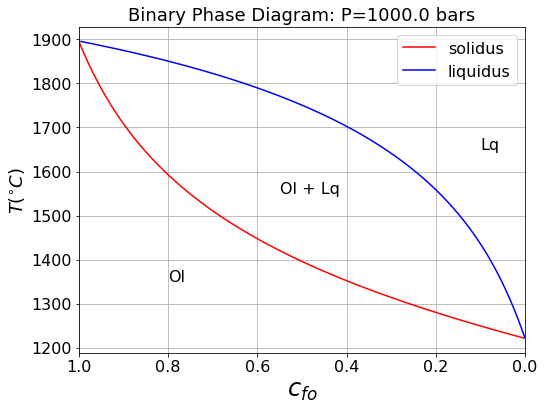

In [16]:
P = 1000.
labels = [ (0.8,1350.,'Ol'), (0.55,1550.,'Ol + Lq'), (0.1,1650.,'Lq')]
fig, ax = plot_phase_diagram(P, rxn, labels=labels)

### Isothermal disequilibrium kinetics

In addition to equilibrium calculations, we can also use the kinetic reaction rates $\Gamma_i$ and $\Gamma_i^k$ to calculate the approach to equilibrium from an initial disequilibrium configuration.  As the simplest system, here we consider the melting of meta-stable Olivine at $T=1600^\circ$ C with negligible initial melt.

For an isothermal system that is closed to mass, we can write conservation of mass equations for each phase and component as the system of ODE's

$$
    \frac{d M_i}{d t} = \Gamma_i V(t)
$$

$$
    \frac{d M_i c_i^k}{d t} = \Gamma_i^k V(t)
$$

where $M_i$ is the mass of phase $i$,  $c_i^k$ is the mass fraction of component $k$ in phase $i$ and 

$$
    V(t) = \sum_i \frac{M_i}{\rho_i}
$$

is the total volume occupied by all phases which depends on the mass of each phase and its intrinsic density.  In addition, the phase fraction of each phase is 

$$
    \phi_i = \frac{M_i}{\rho_i V}
$$

We can also rewrite the problem as a system of ODE's for just the mass of the phases $M_i$ and the Fo content of each phase $c_i^{Fo}$

$$
    \frac{d M_i}{d t} = \Gamma_i V(t)
$$

$$
    \frac{d c_i^{Fo}}{d t} = \frac{1}{M_i}(\Gamma_i^{Fo} - c_i^{Fo}\Gamma_i)V(t)
$$

### Initial Conditions

To solve this system of ODE's we also need to specify initial conditions for the phase masses and compositions.  Inspection of the second equation above shows that if we start with no melt $M_{Lq}=0$, then the change in melt composition is unbounded unless the initial melt satisfies

$$
    \Gamma_{Lq}^{Fo}(T,P,C,\mathbf{\Phi}) - c_{Lq}^{Fo}\Gamma_i(T,P,C,\mathbf{\Phi}) = 0
$$

which is a non-linear root finding problem for $c_{Lq}^{Fo}$.  Alternatively we can recast this problem as a constrained optimization problem to find the initial liquid composition $\mathbf{c}_{Lq}$ that minimizes the above expression with the constraints  

$$
    \mathbf{c}_{Lq}^T\mathbf{1} = 1,\quad c_{Lq}^k \in [0,1]
$$

i.e. the concentration of melt components must sum to 1 and both are positive.  

`scipy.optimize` provides a useful routine `minimize` that provides bounded/constrained optimization problems

In [17]:
from scipy.optimize import minimize, LinearConstraint, Bounds

Set initial Temperature, Pressure, and initial guess for the concentrations


In [18]:
T = toKelvin(1600.)
P = 1000.
Phi = np.array([1., 0.])
C = rxn.zero_C()
C[iOl] = [.5, .5]
C[iLq] = [.5, .5]


define the function and constraints to be passed to `minimize`.

In [19]:
def fmin(cLq,T,P,C,Phi):
    """ function to return || MdC/dT|| """
    C[iLq] = cLq
    res = np.array(rxn.Gamma_ik(T,P,C,Phi)[iLq]) - np.array(C[iLq])*rxn.Gamma_i(T,P,C,Phi)[iLq]
    return np.linalg.norm(res)

#constraints and bounds
lc = LinearConstraint(np.ones(2),1.,1.)
bnds = Bounds(np.zeros(2),np.ones(2))

Call minimize and check solution

In [20]:
c0 = C[iLq].copy()
sol = minimize(fmin, c0, args=(T, P, C, Phi),bounds=bnds,constraints=lc)
print('{}'.format(sol.message))

Optimization terminated successfully


/tmp/ipykernel_810/2924401832.py:4: RuntimeWarning: invalid value encountered in multiply
  res = np.array(rxn.Gamma_ik(T,P,C,Phi)[iLq]) - np.array(C[iLq])*rxn.Gamma_i(T,P,C,Phi)[iLq]


In [21]:
cf0 = sol.x
C[iLq] = cf0.tolist()
print('C = {}'.format(C))
print('residual = {}, sum(cf)= {}'.format(fmin(cf0,T,P,C,Phi),np.sum(cf0)))

C = [[0.5, 0.5], [0.1403311009766579, 0.8596688990233422]]
residual = 1.3733954950833545e-09, sum(cf)= 1.0


In [22]:
print('Gamma_ik = {}'.format(np.array(rxn.Gamma_ik(T,P,C,Phi))))
print('Gamma_i  = {}'.format(rxn.Gamma_i(T,P,C,Phi)))

Gamma_ik = [[-0.08476226 -0.51925397]
 [ 0.08476226  0.51925397]]
Gamma_i  = [-0.6040162373894019, 0.6040162373894019]


### Solve the Initial Value problem

We will now use `scipy.integrate.solve_ivp` to solve the ODE initial value problem described above starting with 100 g of Olivine and an infinitesmal amount of melt

We start by defining the RHS function of the ODE system 

$$
    \frac{d\mathbf{u}}{dt} = \mathbf{f}(t,\mathbf{u})
$$

Where
$$
    \mathbf{u} = \begin{bmatrix} M_{Ol}\\ M_{Lq}\\ c_{Ol}^{Fo} \\ c_{Lq}^{Fo} \\ \end{bmatrix},\quad
    \mathbf{f} = \begin{bmatrix} \Gamma_{Ol}\\ \Gamma_{Lq} \\(\Gamma_{Ol}^{Fo} - c_{Ol}^{Fo}\Gamma_{Ol})/M_{Ol}\\ (\Gamma_{Lq}^{Fo} - c_{Lq}^{Fo}\Gamma_{Lq})/M_{Lq}\\ \end{bmatrix}V(t)
$$

In [23]:
def rhs(t, u, rxn, T, P ):
    """ RHS function of ODE problem for disequilibrium reaction path modeling in the Fo-Fa melting system"""
    
    # extract Mass M and forsterite concentration c of each phase
    N = 2
    M = u[:N]
    c = u[N:]
    
    # Set the total concentration matrix given the forsterite compositions
    C = rxn.zero_C()
    C[iOl] = [ c[iOl], 1. - c[iOl]]
    C[iLq] = [ c[iLq], 1. - c[iLq]]
    
    # calculate total volume V and phase fractions Phi
    V_i = M/np.array(rxn.rho(T,P,C))
    V = np.sum(V_i)
    Phi = V_i/V
    
    # calculate RHS of ODE
    du = V*np.ones(4)
    du[:N] *=  np.array(rxn.Gamma_i(T,P,C,Phi))
    Gik = rxn.Gamma_ik(T,P,C,Phi)
    Gi  = rxn.Gamma_i(T,P,C,Phi)
    for i in range(N):
        dc = (np.array(Gik[i]) - np.array(C[i])*Gi[i])/M[i]
        du[N+i] *= dc[kFo]
    
    return du
    
    

#### Set the initial conditions on mass and concentration

Here we will start with 100 g of Olivine with composition $c_{Ol} = \begin{bmatrix} 0.5 & 0.5\\\end{bmatrix}$ and $10^{-3}$ g of Liquid (to avoid the zero divide in the ODE at zero liquid mass) with the initial **disequilibrium** concentration calculated above.  Note, in kinetic systems the composition of the first melt is not guaranteed to be an equilibrium melt,  but rather is governed by the relative rates of the different melting reactions.

In [24]:
# Initial Masses
M0 = np.array([100., 1.e-3])

# Initial Forsterite composition of Olivine and Liquid
c0 = [ C[i][kFo] for i in range(2)]

# concatenate mass and concentration into an initial condition u0 and test the RHS
u0 = np.concatenate((M0,c0),axis = None)
print('u_0  = {}'.format(u0))
print('du_0 = {}'.format(rhs(0.,u0,rxn,T,P)))

u_0  = [1.00000000e+02 1.00000000e-03 5.00000000e-01 1.40331101e-01]
du_0 = [-1.72846935e+00  1.72846935e+00  6.21676665e-03  2.77903294e-06]


Note that at this initial condition,  Olivine is decreasing and melt increasing as expected.  

### Solve the initial value problem

We now use scipy's ODE suite `scipy.integrate.solve_ivp` to solve this problem using the adaptive Radau method for stiff systems.

In [25]:
from scipy.integrate import solve_ivp

In [26]:
f = lambda t,u : rhs(t, u, rxn, T, P)
t_span=(0., 200.)
sol = solve_ivp(f, t_span, u0, method='Radau', rtol=1.e-6, atol=1.e-10)

and extract Temperature and Compositional data for plotting on the phase diagram. 

In [27]:
data = np.zeros((len(sol.t),3))

# set constant Temperature array of the length of the number of time steps
data[:,0] = toCelsius(T)*np.ones(len(sol.t))

# extract Forsterite content of solid (sol.y[2,:]) and liquid (sol.y[3,:])
data[:,1] = sol.y[2,:]
data[:,2] = sol.y[3,:]

and plot

T_min=1221.301894881114 C, T_max=1896.1787129195568 C


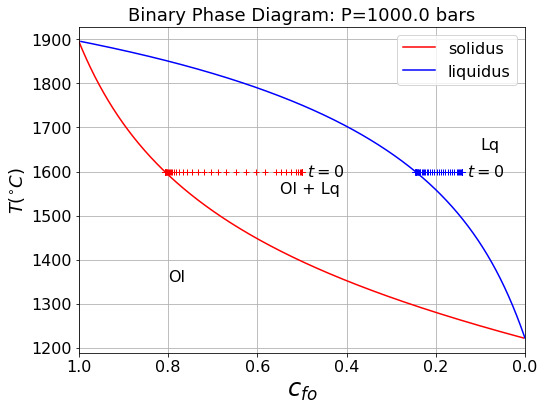

In [28]:
tlabels = [ (c0[0], 1590., ' $t=0$'), (c0[1], 1590., ' $t=0$')]
fig,ax = plot_phase_diagram(P,rxn,data=data, labels=labels + tlabels)

The crosses denote the evolution of the initial solid and melt compositions at $t=0$ as they approach their equilbrium values at $T=1600^\circ$ C.  **Note**: The initial liquid from is not an equilibrium melt, but is actually more Fe rich.  

The evolution of phase Masses and compositions from the time-dependent calculation, as well as total volume and phase fractions can also be plotted

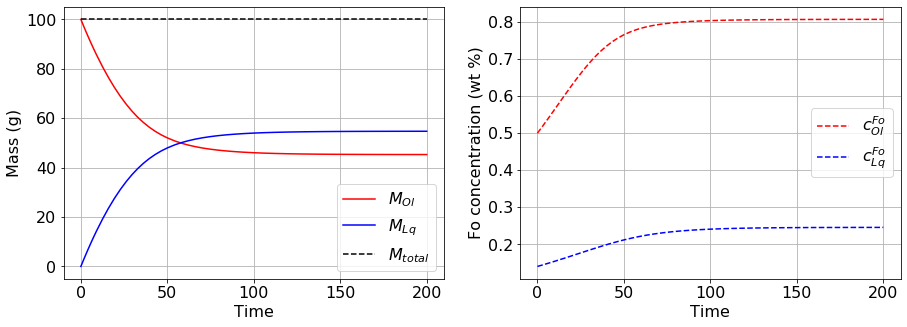

In [29]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(sol.t,sol.y[0],'r', label='$M_{Ol}$')
ax.plot(sol.t,sol.y[1],'b', label='$M_{Lq}$')
ax.plot(sol.t,sol.y[0]+sol.y[1],'k--',label='$M_{total}$')
ax.set_xlabel('Time')
ax.set_ylabel('Mass (g)')
ax.grid()
ax.legend(loc='best')

ax = fig.add_subplot(1,2,2)
ax.plot(sol.t,sol.y[2],'r--', label='$c_{Ol}^{Fo}$')
ax.plot(sol.t,sol.y[3],'b--', label='$c_{Lq}^{Fo}$')
ax.set_xlabel('Time')
ax.set_ylabel('Fo concentration (wt %)')
ax.grid()
ax.legend(loc='best')
plt.show()

### Calculate Phase fractions densities total volume

In [30]:
def getPhiVrho(sol,T,P):
    ''' return phase fractions, densities  and total volume from a reaction path model solution'''
    
    cFoOl = sol.y[2]
    cFoLq = sol.y[3]
    
    C = rxn.zero_C()
    Phi = np.zeros((2,len(sol.t)))
    Rho = Phi.copy()
    V = np.zeros(len(sol.t))
    
    for i in range(len(sol.t)):
        C[iOl] = [ cFoOl[i], 1. - cFoOl[i]]
        C[iLq] = [ cFoLq[i], 1. - cFoLq[i]]
        Rho[:,i] = np.array(rxn.rho(T,P,C))
        V_i = sol.y[:2,i]/Rho[:,i]
        V[i] = V_i.sum()
        Phi[:,i] = V_i/V[i]
        
    return Phi, V, Rho
        

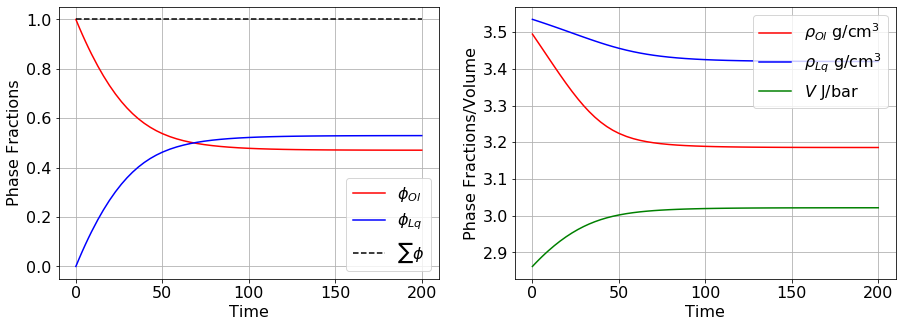

In [31]:
Phi,V,Rho = getPhiVrho(sol,T,P)

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(sol.t,Phi[0],'r', label='$\phi_{Ol}$')
ax.plot(sol.t,Phi[1],'b', label='$\phi_{Lq}$')
ax.plot(sol.t,Phi[0]+Phi[1],'k--', label='$\sum\phi$')
ax.set_xlabel('Time')
ax.set_ylabel('Phase Fractions')
ax.grid()
ax.legend(loc='best')

ax = fig.add_subplot(1,2,2)
ax.plot(sol.t,Rho[0]/10,'r', label='$\\rho_{Ol}$ g/cm$^3$')
ax.plot(sol.t,Rho[1]/10,'b', label='$\\rho_{Lq}$ g/cm$^3$')
ax.plot(sol.t,V,'g', label='$V$ J/bar')
ax.set_xlabel('Time')
ax.set_ylabel('Phase Fractions/Volume')
ax.grid()
ax.legend(loc='best')
plt.show()